<a href="https://colab.research.google.com/github/HollowMike8/yolo-object-detection-with-opencv/blob/main/yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git
!git init

In [2]:
!git clone https://github.com/HollowMike8/yolo-object-detection-with-opencv.git

Cloning into 'yolo-object-detection-with-opencv'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 1), reused 12 (delta 1), pack-reused 0
Unpacking objects: 100% (12/12), done.


In [3]:
%cd yolo-object-detection-with-opencv/

/content/yolo-object-detection-with-opencv


In [15]:
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

In [30]:
path_dir: str = r"/content/yolo-object-detection-with-opencv"

In [6]:
# load the COCO class labels for YOLO model
labels_path = os.path.join(path_dir, "yolo-coco", "coco.names")
labels = open(labels_path, "r").read().strip().split("\n")

# assign random colours to all COCO class labels
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype = "uint8")

In [ ]:
# download the files if required

# change the dir to location where downloads save
%cd /content/yolo-object-detection-with-opencv/yolo-coco/

!wget "https://pjreddie.com/media/files/yolov3.weights"

!wget "https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg"

# !wget "https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names"

#change the dir back to root dir
%cd /content/yolo-object-detection-with-opencv/

In [36]:
# load the yolov3 model
weightsPath = os.path.join(path_dir, "yolo-coco", "yolov3.weights")
configPath = os.path.join(path_dir, "yolo-coco", "yolov3.cfg")

net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

In [42]:
# load the image
img_dir = os.path.join(path_dir, "images")
filename = np.random.choice(os.listdir(img_dir))
image_path = os.path.join(img_dir, filename)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
h, w = image.shape[:2]

# determine only *output* layer names that we need from yolo (3 output layers)
layer_names = net.getLayerNames()
layer_names = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# construct a blob from the input image and then perform a forward pass
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, 
                             crop=False)

net.setInput(blob)
start = time.time()
layerOutputs = net.forward(layer_names)
end = time.time()

# show the computation time
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

[INFO] YOLO took 1.957264 seconds


In [43]:
# initialize lists to append the bounding boxes, confidences and class IDs
boxes = []
confidences = []
classIDs = []

# loop over each layer of the outputs (3)
for output in layerOutputs:
  # loop over the detections in each output
  for detection in output:
    scores = detection[5:]
    classID = np.argmax(scores)
    confidence = scores[classID]

    # consider only predictions with confidence with > 0.5
    if confidence > 0.5:
      # scale the bounding box parameters 
      box = detection[0:4] * np.array([w, h, w, h])
      (centerX, centerY, width, height) = box.astype("int")

      # find the top left corner point for cv2.rectangle
      x = int(centerX - (width/2))
      y = int(centerY - (height/2))

      boxes.append([x, y, int(width), int(height)])
      confidences.append(float(confidence))
      classIDs.append(classID)

In [44]:
# apply non-max supression with threshold IoU= 0.3 and threshold confidence=0.5
idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

In [45]:
# plot the bounding boxes and write class labels, confidence values
if len(idxs) > 0:
  for i in idxs.flatten():
    # extract the top left corner, dims of the bounding box
    (x, y) = (boxes[i][0], boxes[i][1])   
    (w, h) = (boxes[i][2], boxes[i][3])

    color = [int(c) for c in colors[classIDs[i]]]
    cv2.rectangle(image, (x,y), (x+w,y+h), color, 2)
    text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
    cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, 
                color, 2)

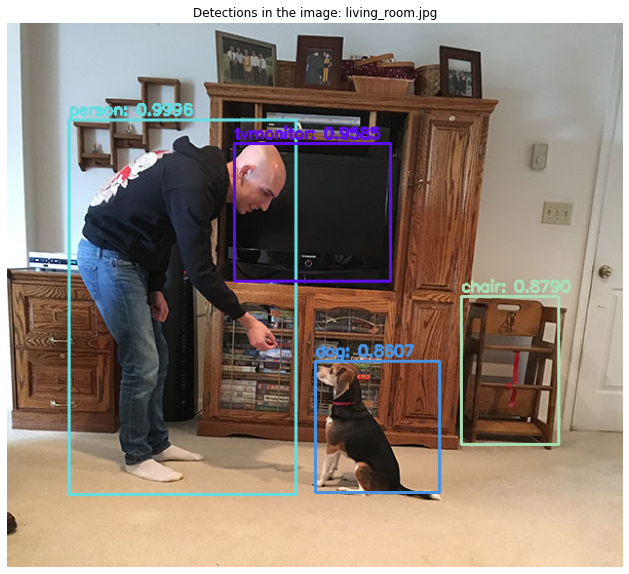

In [46]:
# plot the image
fig = plt.figure(figsize = (15,10))
plt.imshow(image)
plt.title("Detections in the image: %s"% filename)
plt.axis("off")

plt.show()